# SINR Test Distribution

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import special

def euclidean_dist(row):
    # Function to calc euclidean distance on every df row 
    euc_dist = math.sqrt(row["U2G_Distance"]**2 - row["Height"]**2)
    return euc_dist

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    elif env == 'urban':
        a1 = 0.3
        a2 = 5e-4
        a3 = 15
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        if delta_h < 0:
            h1 = height_rx
            h2 = height_tx
        else:
            h1 = height_tx
            h2 = height_rx
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(h1/a3) - q_func(h2/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    elif env == "urban":
        n_min = 1.9
        n_max = 2.7
        K_dB_min = -5
        K_dB_max = 15
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 10.42 # Env parameters for logarithm std dev of shadowing 
        beta = 0.05 # Env parameters for logarithm std dev of shadowing 
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env=env)
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR


def lognormal_pdf(x, mu, sigma):
    y = math.exp(-(math.log(x)-mu)**2./(2*sigma**2)) / (math.sqrt(2*math.pi)*sigma*x)
    return y

def gamma_pdf(x, k, theta):
    y = (x**(k-1)/(theta**k*special.gamma(k)))*math.exp(-x/theta)
    return y

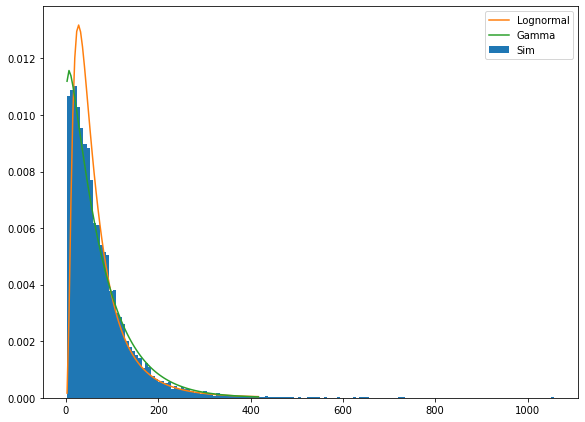

In [15]:

test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_NP10000_BPSK_6-5Mbps_processed/NumMember-7_InterUAVDistance-5_Height-24_Distance-550_PacketSize-24_SendingRate-40_downlink.csv")
# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_NP10000_BPSK_6-5Mbps_processed/NumMember-15_InterUAVDistance-5_Height-24_Distance-550_PacketSize-248_SendingRate-424_downlink.csv")

sinr = test_data["U2G_SINR"]
mean_sinr = sinr.mean()
std_dev_sinr = sinr.std()

# Lognormal params
sigma = math.sqrt(math.log(std_dev_sinr**2/mean_sinr**2 + 1))
mu = math.log(mean_sinr) - sigma**2/2

# Gamma params
k = mean_sinr**2 / std_dev_sinr**2
theta = std_dev_sinr**2 / mean_sinr

pdf_range = mean_sinr + 5*std_dev_sinr
# x = np.linspace(lognorm.ppf(0.01, sigma, loc=mu),
#                 lognorm.ppf(0.99, sigma, loc=mu), 100)
# pdf_ln = lognorm.pdf(x, sigma, loc=mu)
x = np.linspace(sinr.min(), sinr.min()+pdf_range, 100)
pdf_ln = [lognormal_pdf(X, mu, sigma) for X in x]
pdf_gamma = [gamma_pdf(X, k, theta) for X in x]
 
fig = plt.figure(figsize=(9.6,7.2))
plt.hist(sinr, 150, density=True)
plt.plot(x, pdf_ln)
plt.plot(x, pdf_gamma)
plt.legend(("Lognormal", "Gamma", "Sim"))
plt.show()


In [16]:
print(mean_sinr)
print(std_dev_sinr)
print(mu)
print(sigma)
print(math.exp(mu+sigma**2/2))
print(math.sqrt((math.exp(sigma**2)-1)*math.exp(2*mu+sigma**2)))

71.84936263587497
68.5241828350592
3.9511295385790888
0.8042912446947741
71.84936263587494
68.52418283505915


## Compare Simulated SINR Distribution with Theoretical

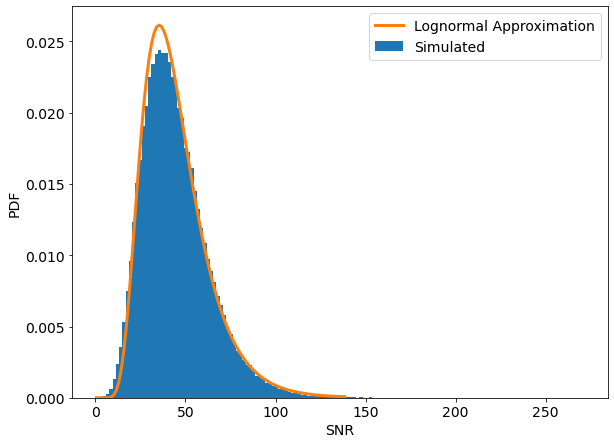

Simulated Mean SINR: 44.465506907074435, Simulated Std Dev SINR: 18.434118331079137
Theoretical Mean SINR: 44.909745738282425, Theoretical Std Dev SINR: 18.60863942754282


In [43]:
height = 300
h_dist = 0
distance = math.sqrt(height**2 + h_dist**2)

test_data = pd.read_csv("/home/research-student/omnetpp_sim_results/SINR_Test_Swarm/data/NumMember-7_InterUAVDistance-5_Height-300_Distance-0_Modulation-QAM-64_UAVSendingInterval-20_SINR.csv")
min_index = np.argmin(np.abs(distance - test_data["Distance"].unique()))
gateway_dist = test_data["Distance"].unique()[min_index]
sinr = test_data.loc[test_data["Distance"] == gateway_dist, 'SINR']
mean_sinr_sim = sinr.mean()
std_dev_sinr_sim = sinr.std()

# Get theoretical mean and std dev of SINR

mean_sinr, std_dev_sinr = sinr_lognormal_approx(h_dist, height)

# Lognormal params
sigma = math.sqrt(math.log(std_dev_sinr**2/mean_sinr**2 + 1))
mu = math.log(mean_sinr) - sigma**2/2

# Gamma params
k = mean_sinr**2 / std_dev_sinr**2
theta = std_dev_sinr**2 / mean_sinr

pdf_range = mean_sinr + 5*std_dev_sinr
# x = np.linspace(lognorm.ppf(0.01, sigma, loc=mu),
#                 lognorm.ppf(0.99, sigma, loc=mu), 100)
# pdf_ln = lognorm.pdf(x, sigma, loc=mu)
x = np.linspace(sinr.min(), sinr.min()+pdf_range, 100)
pdf_ln = [lognormal_pdf(X, mu, sigma) for X in x]
pdf_gamma = [gamma_pdf(X, k, theta) for X in x]
 
fig = plt.figure(figsize=(9.6,7.2))
plt.hist(sinr, 150, density=True)
plt.plot(x, pdf_ln, linewidth=3)
# plt.plot(x, pdf_gamma)
plt.xlabel("SNR")
plt.ylabel("PDF")
plt.legend(("Lognormal Approximation", "Simulated"))
plt.show()

print("Simulated Mean SINR: {}, Simulated Std Dev SINR: {}".format(mean_sinr_sim, std_dev_sinr_sim))
print("Theoretical Mean SINR: {}, Theoretical Std Dev SINR: {}".format(mean_sinr, std_dev_sinr))


## Get Simulated and Theoretical Means and Std Devs of SINR

In [2]:
h_dist = np.linspace(0,1200,num=61,endpoint=True)
height = np.linspace(60,300,num=9,endpoint=True)
mean_sinr_sim = np.zeros((len(height),len(h_dist)))
std_dev_sinr_sim = np.zeros((len(height),len(h_dist)))
mean_sinr = np.zeros((len(height),len(h_dist)))
std_dev_sinr = np.zeros((len(height),len(h_dist)))


for i in range(len(height)):
    for j in range(len(h_dist)):
        [m_sinr, std_sinr] = sinr_lognormal_approx(h_dist[j], height[i])
        # mean_sinr[i,j] = m_sinr # Store mean in linear scale
        # std_dev_sinr[i,j] = std_sinr # Store std dev in linear scale
        mean_sinr[i,j] = 10*math.log10(m_sinr) # Store mean in dB
        std_dev_sinr[i,j] = 10*math.log10(std_sinr) # Store std dev in dB
        # Get simulated mean and std dev
        test_data = pd.read_csv("/home/research-student/omnetpp_sim_results/SINR_Test_Swarm/data/NumMember-7_InterUAVDistance-5_Height-{}_Distance-{}_Modulation-QAM-64_UAVSendingInterval-100_SINR.csv".format(str(int(height[i])), str(int(h_dist[j]))))
        distance = math.sqrt(height[i]**2 + h_dist[j]**2)
        min_index = np.argmin(np.abs(distance - test_data["Distance"].unique()))
        gateway_dist = test_data["Distance"].unique()[min_index]
        sinr = test_data.loc[test_data["Distance"] == gateway_dist, 'SINR']
        # sinr = test_data["SINR"]
        # mean_sinr_sim[i,j] = sinr.mean() # Store mean in linear scale
        # std_dev_sinr_sim[i,j] = sinr.std() # Store std dev in linear scale
        mean_sinr_sim[i,j] = 10*math.log10(sinr.mean()) # Store mean in dB
        std_dev_sinr_sim[i,j] = 10*math.log10(sinr.std()) # Store std dev in dB


In [5]:
abs_diff_mean = np.abs(mean_sinr_sim - mean_sinr)
abs_diff_std_dev = np.abs(std_dev_sinr_sim - std_dev_sinr)

In [7]:
np.max(abs_diff_std_dev)

5.863731333404274

## Plot Sim and Calc Mean and Std Dev in Log Scale

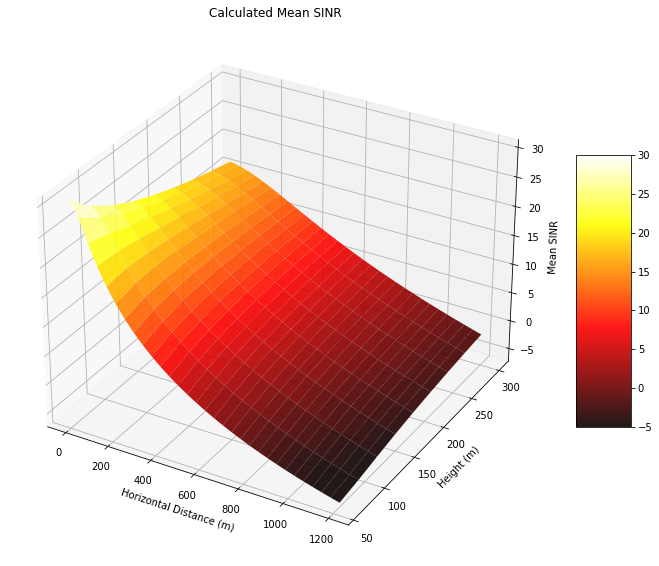

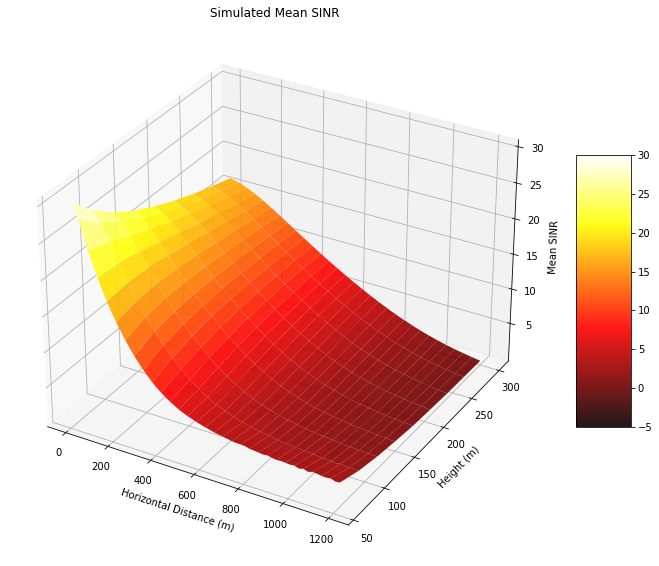

In [3]:
# Plot Theoretical Mean
# Creating figure
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize =(12, 10))
ax = plt.axes(projection ='3d')
 
# Creating color map
my_cmap = plt.get_cmap('hot')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax.plot_surface(H_DIST, HEIGHT, mean_sinr.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                       vmin = -5, vmax=30,
                       alpha=0.9)

fig.colorbar(surf, ax = ax,
             shrink = 0.5, aspect = 5)

ax.set_title('Calculated Mean SINR')
ax.set_xlabel("Horizontal Distance (m)")
ax.set_ylabel("Height (m)")
ax.set_zlabel("Mean SINR")

# Plot Simulated Mean
# Creating figure
fig1 = plt.figure(figsize =(12, 10))
ax1 = plt.axes(projection ='3d')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax1.plot_surface(H_DIST, HEIGHT, mean_sinr_sim.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                       vmin = -5, vmax=30,
                       alpha=0.9)

fig1.colorbar(surf, ax= ax1,
             shrink= 0.5, aspect= 5)

ax1.set_title('Simulated Mean SINR')
ax1.set_xlabel("Horizontal Distance (m)")
ax1.set_ylabel("Height (m)")
ax1.set_zlabel("Mean SINR")

# show plot
plt.show()

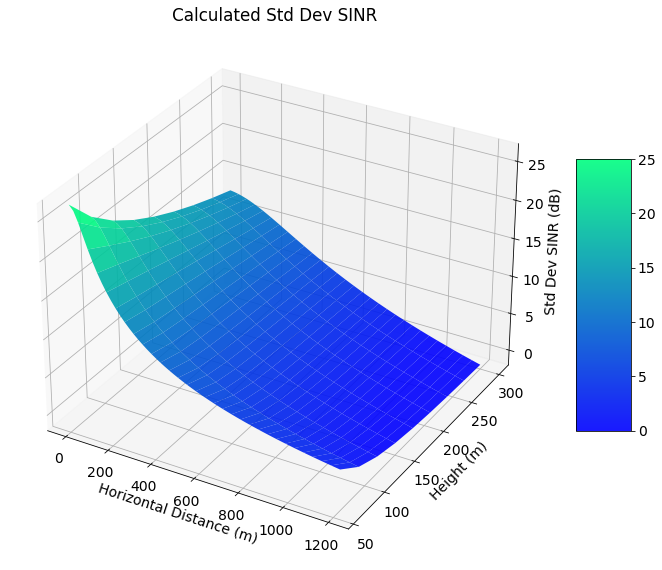

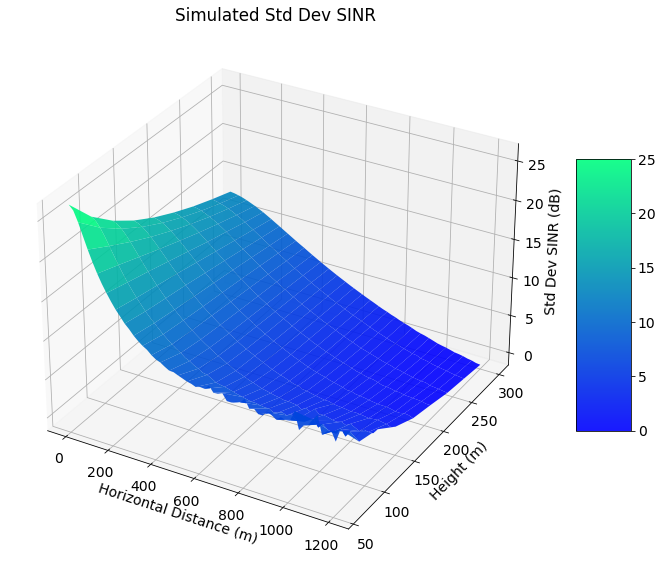

In [4]:
# Plot Theoretical Mean
# Creating figure
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize =(12, 10))
ax = plt.axes(projection ='3d')
 
# Creating color map
my_cmap = plt.get_cmap('winter')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax.plot_surface(H_DIST, HEIGHT, std_dev_sinr.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                       vmin = 0, vmax=25,
                       alpha=0.9)

fig.colorbar(surf, ax = ax,
             shrink = 0.5, aspect = 5)
 
ax.set_title('Calculated Std Dev SINR')
ax.set_xlabel("Horizontal Distance (m)")
ax.set_ylabel("Height (m)")
ax.set_zlabel("Std Dev SINR (dB)")

# Plot Simulated Mean
# Creating figure
fig1 = plt.figure(figsize =(12, 10))
ax1 = plt.axes(projection ='3d')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax1.plot_surface(H_DIST, HEIGHT, std_dev_sinr_sim.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                       vmin = 0, vmax=25,
                       alpha=0.9)

fig1.colorbar(surf, ax= ax1,
             shrink= 0.5, aspect= 5)
 
ax1.set_title('Simulated Std Dev SINR')
ax1.set_xlabel("Horizontal Distance (m)")
ax1.set_ylabel("Height (m)")
ax1.set_zlabel("Std Dev SINR (dB)")

# show plot
plt.show()

## Plot Sim and Calc Mean and Std Dev SINR in Linear Scale

In [8]:
mean_sinr_sim_linear = np.zeros((len(height),len(h_dist)))
std_dev_sinr_sim_linear = np.zeros((len(height),len(h_dist)))
mean_sinr_linear = np.zeros((len(height),len(h_dist)))
std_dev_sinr_linear = np.zeros((len(height),len(h_dist)))

# Convert To Linear Scale
for i in range(len(height)):
    for j in range(len(h_dist)):
        mean_sinr_linear[i,j] = 10**(mean_sinr[i,j]/10)
        std_dev_sinr_linear[i,j] = 10**(std_dev_sinr[i,j]/10)
        mean_sinr_sim_linear[i,j] = 10**(mean_sinr_sim[i,j]/10)
        std_dev_sinr_sim_linear[i,j] = 10**(std_dev_sinr_sim[i,j]/10)

In [9]:
abs_diff_mean = np.abs(mean_sinr_sim_linear - mean_sinr_linear)
abs_diff_std_dev = np.abs(std_dev_sinr_sim_linear - std_dev_sinr_linear)
print(np.max(abs_diff_mean))
print(np.max(abs_diff_std_dev))

47.7683003295017
9.79233223847018


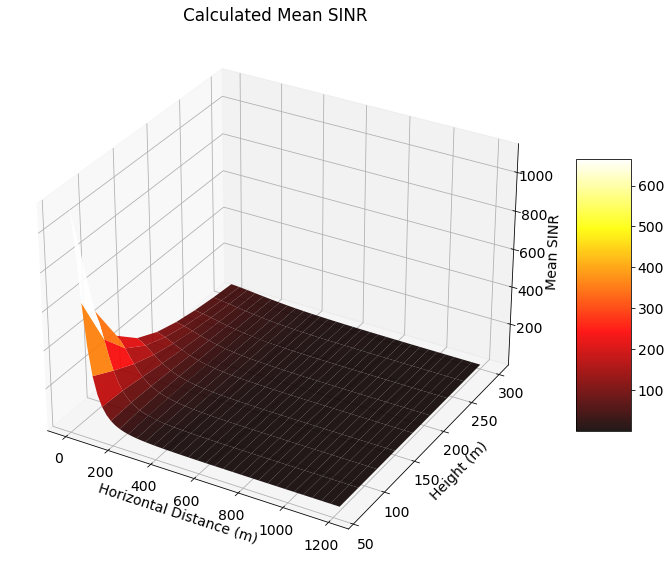

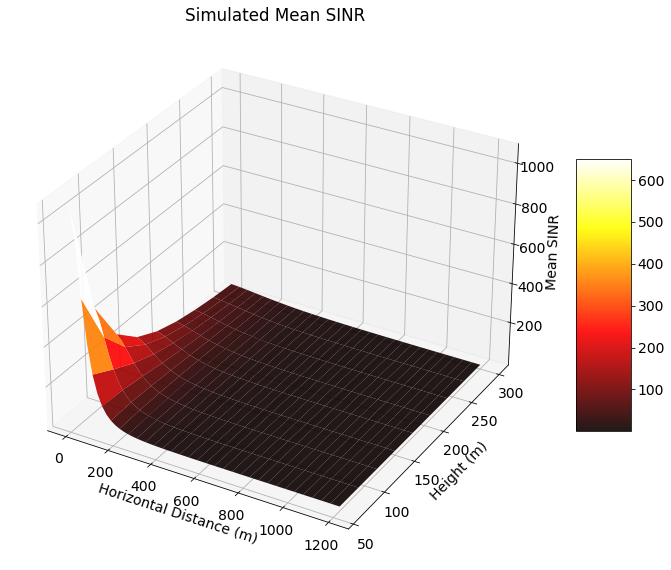

In [89]:
# Plot Theoretical Mean
# Creating figure
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize =(12, 10))
ax = plt.axes(projection ='3d')
 
# Creating color map
my_cmap = plt.get_cmap('hot')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax.plot_surface(H_DIST, HEIGHT, mean_sinr_linear.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                    #    vmin = -5, vmax=30,
                       alpha=0.9)

fig.colorbar(surf, ax = ax,
             shrink = 0.5, aspect = 5)

ax.set_title('Calculated Mean SINR')
ax.set_xlabel("Horizontal Distance (m)")
ax.set_ylabel("Height (m)")
ax.set_zlabel("Mean SINR")

# Plot Simulated Mean
# Creating figure
fig1 = plt.figure(figsize =(12, 10))
ax1 = plt.axes(projection ='3d')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax1.plot_surface(H_DIST, HEIGHT, mean_sinr_sim_linear.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                    #    vmin = -5, vmax=30,
                       alpha=0.9)

fig1.colorbar(surf, ax= ax1,
             shrink= 0.5, aspect= 5)

ax1.set_title('Simulated Mean SINR')
ax1.set_xlabel("Horizontal Distance (m)")
ax1.set_ylabel("Height (m)")
ax1.set_zlabel("Mean SINR")

# show plot
plt.show()

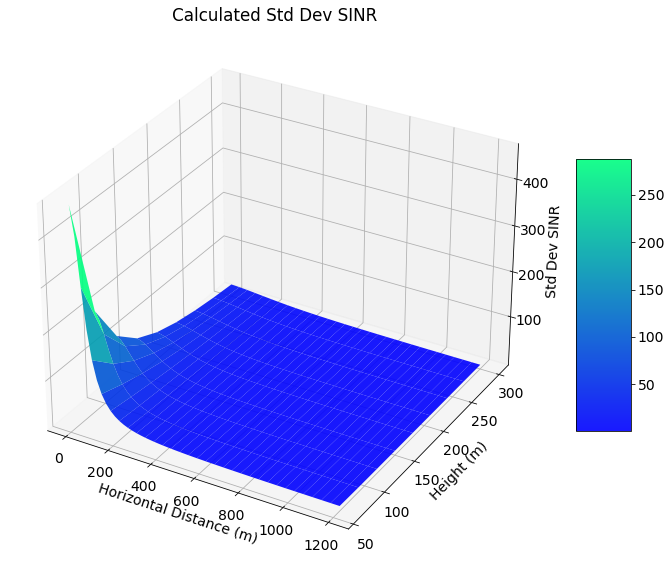

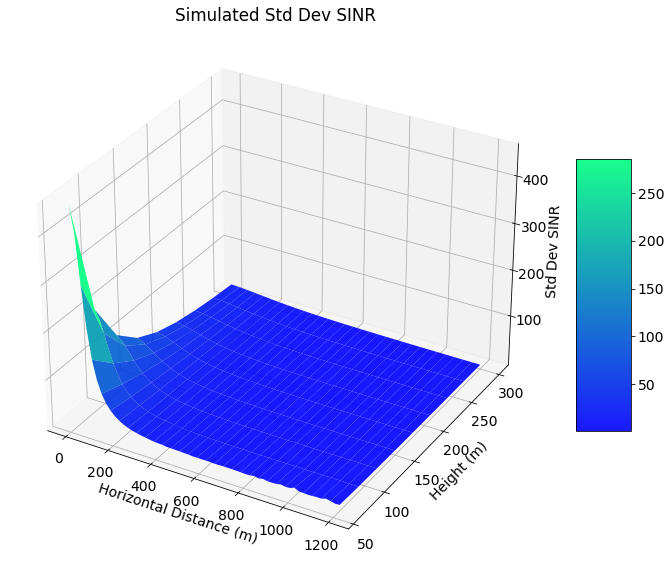

In [92]:
# Plot Theoretical Mean
# Creating figure
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize =(12, 10))
ax = plt.axes(projection ='3d')
 
# Creating color map
my_cmap = plt.get_cmap('winter')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax.plot_surface(H_DIST, HEIGHT, std_dev_sinr_linear.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                    #    vmin = 0, vmax=25,
                       alpha=0.9)

fig.colorbar(surf, ax = ax,
             shrink = 0.5, aspect = 5)
 
ax.set_title('Calculated Std Dev SINR')
ax.set_xlabel("Horizontal Distance (m)")
ax.set_ylabel("Height (m)")
ax.set_zlabel("Std Dev SINR")

# Plot Simulated Mean
# Creating figure
fig1 = plt.figure(figsize =(12, 10))
ax1 = plt.axes(projection ='3d')

# Creating plot
H_DIST = np.outer(h_dist, np.ones(len(height)))
HEIGHT = np.outer(height, np.ones(len(h_dist))).T
surf = ax1.plot_surface(H_DIST, HEIGHT, std_dev_sinr_sim_linear.T,
                       cmap = my_cmap,
                       edgecolor ='none',
                    #    vmin = 0, vmax=25,
                       alpha=0.9)

fig1.colorbar(surf, ax= ax1,
             shrink= 0.5, aspect= 5)
 
ax1.set_title('Simulated Std Dev SINR')
ax1.set_xlabel("Horizontal Distance (m)")
ax1.set_ylabel("Height (m)")
ax1.set_zlabel("Std Dev SINR")

# show plot
plt.show()